In [6]:
from dotenv import load_dotenv
import os

load_dotenv()  # This loads the environment variables from .env

api_key = os.getenv('HGF_KEY')


In [7]:
import sys
sys.path

['/home/ubuntu/.cache/torch/hub/pytorch_fairseq_main',
 '/mnt/efs/fs1/mmml/11777-project/neural_symbolic',
 '/mnt/efs/fs1/mmml/miniconda3/envs/cenv_x86/lib/python38.zip',
 '/mnt/efs/fs1/mmml/miniconda3/envs/cenv_x86/lib/python3.8',
 '/mnt/efs/fs1/mmml/miniconda3/envs/cenv_x86/lib/python3.8/lib-dynload',
 '',
 '/mnt/efs/fs1/mmml/miniconda3/envs/cenv_x86/lib/python3.8/site-packages']

In [8]:
import json
from pathlib import Path

In [9]:
dataset_base = Path('/mnt/efs/fs1/mmml/why-winoground-hard/dataset/')
with (dataset_base/'examples.jsonl').open() as f:
    dl = [json.loads(l) for l in f]

### Load Parser

In [10]:
from transition_amr_parser.parse import AMRParser

# Download and save a model named AMR3.0 to cache
parser = AMRParser.from_pretrained('AMR3-structbart-L')

load from cache /home/ubuntu/.cache/torch/DATA/AMR3.0/models/amr3.0-structured-bart-large-neur-al/seed42/checkpoint_wiki.smatch_top5-avg.pt
| [en] dictionary: 46088 types
| [actions_nopos] dictionary: 16544 types
----------loading pretrained bart.large model ----------


Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_fairseq_main


---------- task bart rewind: loading pretrained bart.large model ----------


Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_fairseq_main


using GPU for models
pretrained_embed:  bart.large


Using cache found in /home/ubuntu/.cache/torch/hub/pytorch_fairseq_main


Using bart.large extraction in GPU
Finished loading models
self.machine_config:  /home/ubuntu/.cache/torch/DATA/AMR3.0/models/amr3.0-structured-bart-large-neur-al/seed42/machine_config.json


### Parsing function

#### sandbox

Running on batch size: 1
1


decoding: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


# ::tok A brown dog that has a stick
(d / dog~2
    :ARG0-of (h / have-03~4
        :ARG1 (s / stick~6))
    :mod (r / Brown~1))

# ::tok A brown dog that has a stick
(d / dog~2
    :ARG0-of (h / have-03~4
        :ARG1 (s / stick~6))
    :mod (r / Brown~1))



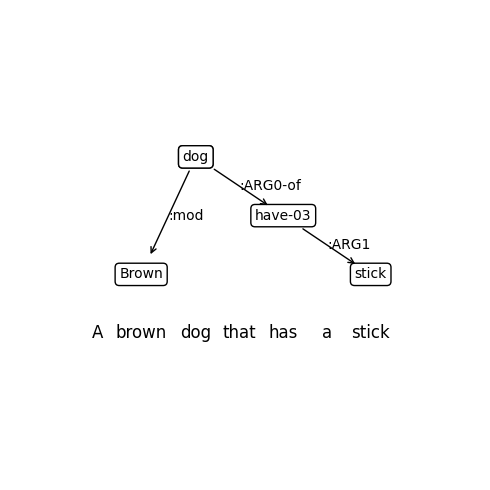

In [38]:
# tokens, positions = parser.tokenize('The girl travels and visits places')
# tokens, positions = parser.tokenize('An old person kisses a young person')
# tokens, positions = parser.tokenize('A young person kisses an old person')
# tokens, positions = parser.tokenize('A dog sits and a cat stands')

tokens, positions = parser.tokenize('A brown dog that has a stick')
# Use parse_sentence() for single sentences or parse_sentences() for a batch
annotations, machines = parser.parse_sentence(tokens)

# Print Penman notation
print(annotations)

# Print Penman notation without JAMR, with ISI
amr = machines.get_amr()
print(amr.to_penman(jamr=False, isi=True))

# Plot the graph (requires matplotlib)
amr.plot()


"""
ground-truth captions -> amr_parse_ref
image -> [encoder ->[adapter (like Fromage)]-> LLM Decoder] (BLIP2) -> captions x N -> amr_parse_pred x N
smatch(amr_parse_ref,amr_parse_pred_i)

I0 -> C0_pred_i i=1...N -> P0_pred_i
I1 -> C1_pred_j j=1...N -> P1_pred_j

image_score 
1/N *\sum_{i=1}^N smatch(C0_ref,C0_pred_i) > 1/N *\sum_{i=1}^N smatch(C0_ref,C1_pred_i)
1/N *\sum_{i=1}^N smatch(C1_ref,C1_pred_i) > 1/N *\sum_{i=1}^N smatch(C1_ref,C0_pred_i) 

text_score
1/N *\sum_{i=1}^N smatch(C0_ref,C0_pred_i) > 1/N *\sum_{i=1}^N smatch(C1_ref,C0_pred_i)
1/N *\sum_{i=1}^N smatch(C1_ref,C1_pred_i) > 1/N *\sum_{i=1}^N smatch(C0_ref,C1_pred_i)
"""

In [15]:
"""
img_i+text_j -> VLM-ENCODER -> embs(img_i), embs(text_j)
embs(img_i) = [ cls_emb, embi1, emgi2, ...., embiN]



1. if we're taking representations from the original caption's contextualized reps, we lose positional information after semantic parse
hard to figure out which position in the encoded caption is the span we need


# sol 1: generate text from AMR (simple methods) -> A cat is eating [something] -> pooled rep
# 

2. if we're taking the execution approach like NMN, we don't have a fixed set of functions as VERBS are open class

text_j -> 
# (k / kiss-01~3 
#     :ARG0 (p / person~2
#         :mod (o / old~1))
#     :ARG1 (p2 / person~6
#         :mod (y / young~5)))


# (k / kiss-01~3
#     :ARG0 (p / person~2
#         :mod (y / young~1))
#     :ARG1 (p2 / person~6
#         :mod (o / old~5)))

# (a / and~3
#     :op1 (s / sit-01~2
#         :ARG1 (d / dog~1))
#     :op2 (s2 / stand-01~6
#         :ARG1 (c / cat~5)))

# # ::tok A fire truck
# (t / truck~2
#     :purpose (f / fire~1))

#  # ::tok A truck fire
# (f / fire-03~2
#     :ARG1 (t / truck~1))

"""

"\nimg_i+text_j -> VLM-ENCODER -> embs(img_i), embs(text_j)\nembs(img_i) = [ cls_emb, embi1, emgi2, ...., embiN]\n\n\n\n1. if we're taking representations from the original caption's contextualized reps, we lose positional information after semantic parse\n2. if we're taking the execution approach like NMN, we don't have a fixed set of functions as VERBS are open class\n\ntext_j -> \n# (k / kiss-01~3 \n#     :ARG0 (p / person~2\n#         :mod (o / old~1))\n#     :ARG1 (p2 / person~6\n#         :mod (y / young~5)))\n\n\n# (k / kiss-01~3\n#     :ARG0 (p / person~2\n#         :mod (y / young~1))\n#     :ARG1 (p2 / person~6\n#         :mod (o / old~5)))\n\n# (a / and~3\n#     :op1 (s / sit-01~2\n#         :ARG1 (d / dog~1))\n#     :op2 (s2 / stand-01~6\n#         :ARG1 (c / cat~5)))\n\n# # ::tok A fire truck\n# (t / truck~2\n#     :purpose (f / fire~1))\n\n#  # ::tok A truck fire\n# (f / fire-03~2\n#     :ARG1 (t / truck~1))\n\n"

In [ ]:
"""
img_i -> CAP -> text_i-hat -> PARSE -> parse_i-hat

-> top-k captions, use BLEU scores to weight/re-rank the smatch scores

text_j-ref -> tokenize -> ref_tok_ids = [42,5,24,543,0,99]

A cat is chasing a dog
[A cat is chas# #ing a dog]

# [A cat is] chasing a dog
# [A cat is] chased by a dog

# An orange cat and a brown dog

# [An orange] cat [and] a brown

# [An orange] ___ [and] [a brown] ___


A dog is chas# #ing cat

text_j-ref -> PARSE -> parse_j-ref

score(img_i,text_j):= smatch(parse_i-hat,parse_j-ref) + a* ged(parse_i-hat,parse_j-ref)

"""

#### Func

In [11]:
def get_amr(sent):
    tokens, positions = parser.tokenize(sent)
    # Use parse_sentence() for single sentences or parse_sentences() for a batch
    annotations, machines = parser.parse_sentence(tokens)
    
    # Print Penman notation without JAMR, with ISI
    amr = machines.get_amr()
    amr_str=amr.to_penman(jamr=False, isi=True)
    return amr_str

In [20]:
def process_amrs(dics,f_stream):
    for d in dics:
        out={
            'id':d['id'],
            'caption_0':d['caption_0'],
            'caption_1':d['caption_1'],
            }
        out['parse_0'] = get_amr(d['caption_0'])
        out['parse_1'] = get_amr(d['caption_1'])
        print(json.dumps(out),file=f_stream,flush=True)
    return

In [23]:
def process_pred_amrs(dics,f_stream):
    for d in dics:
        out={
            'id':d['id'],
            'gen_cap_0':d['gen_cap_0'],
            'gen_cap_1':d['gen_cap_1'],
            'parses_0':[],
            'parses_1':[]
            }
        
        for cap_0,cap_1 in zip(d['gen_cap_0'],d['gen_cap_1']):
            out['parses_0'].append(get_amr(cap_0))
            out['parses_1'].append(get_amr(cap_1))
        print(json.dumps(out),file=f_stream,flush=True)
    return

#### Parse Ground Truth Captions

In [24]:
with open('wino_amrs.jsonl','w') as f:
    process_amrs(dl,f)

Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.11it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.11it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.42it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.41it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.02s/it]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


In [39]:
amr.to_penman()

'# ::tok A brown dog that has a stick\n(d / dog~2\n    :ARG0-of (h / have-03~4\n        :ARG1 (s / stick~6))\n    :mod (r / Brown~1))\n'

In [41]:
# from transition_amr_parser.amr import AMR

In [42]:
# recon = AMR.from_penman(amr.to_penman())
# print(recon.to_penman())

# ::tok A brown dog that has a stick
(d / dog~2
    :ARG0-of (h / have-03~4
        :ARG1 (s / stick~6))
    :mod (r / Brown~1))



In [53]:
with open('wino_amrs.jsonl') as f:
    out_amrs = [json.loads(l) for l in f]

In [59]:
print(out_amrs[0]['parse_1'])

# ::tok a young person kisses an old person
(k / kiss-01~3
    :ARG0 (p / person~2
        :mod (y / young~1))
    :ARG1 (p2 / person~6
        :mod (o / old~5)))



#### Parse Model Predictions

In [25]:
with open('wino_blip2-flant5xl_caps.jsonl') as f:
    pred_captions = [json.loads(l) for l in f]


In [ ]:
with open('wino_blip2-flant5xl_caps_parse.jsonl','w') as f:
    process_pred_amrs(pred_captions,f)

Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.60it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.63it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.40it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.82it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.11it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.11it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.11it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.63it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.86it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.26it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.87it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.24it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.64it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.10it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.88it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.88it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.87it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.25it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.83it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.41it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.11it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.42it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.28it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.99it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.98it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.40it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.41it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.87it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.00it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.60it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.11it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.10it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.24it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.83it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.25it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.70it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.99it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.32it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.13it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.83it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.12it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.97it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.10it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.63it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.11it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.64it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.00it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.99it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.63it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.43it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.65it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.69it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.50it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.85it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.29it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.62it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.81it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding:   0%|                                                          | 0/1 [00:00<?, ?it/s]/mnt/efs/fs1/mmml/miniconda3/envs/cenv_x86/lib/python3.8/site-packages/fairseq_ext/sequence_generator.py:893: UserWarning: max step reached; we should set proper max step value so that this does not happen. OR: the generation is stuck at some repetitive patterns.
  warnings.warn('max step reached; we should set proper max step value so that this does not happen. '
decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.28it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.86it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.94it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.33it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.89it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.07it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.77it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.45it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.54it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.21it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.95it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.08it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.22it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.42it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.90it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.93it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.20it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.27it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.79it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.59it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.55it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.96it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.18it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.73it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.06it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.53it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.52it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.36it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.91it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.16it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.14it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.15it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.09it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.39it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.05it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.71it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.75it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.02it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.84it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.37it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.34it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.04it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.46it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.19it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.47it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.30it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.31it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.58it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.72it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.35it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.17it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.67it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding: 100%|██████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.03it/s]


Running on batch size: 1
1


decoding:   0%|                                                          | 0/1 [00:00<?, ?it/s]

In [ ]:
# score_amr_pairs